<a href="https://colab.research.google.com/github/Nimminhassan/Bullying-Detection-NLP/blob/main/Bullying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SVM**

In [ ]:
# Install dependencies if needed
!pip install emoji scikit-learn

import pandas as pd
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


In [ ]:
def preprocess_text(text):
    # Convert emojis → text labels (e.g., 😡 -> :angry_face:)
    text = emoji.demojize(text, language='en')
    # Replace underscores with spaces to improve TF-IDF tokenization
    text = text.replace("_", " ")
    return text


In [ ]:
!pip install pandas odfpy

In [ ]:
df = pd.read_excel("/content/WS.ods")

df = df.rename(columns={"COMMENTS": "text", "LABELS": "label"})


In [ ]:
df

,text,label
0,Kamra on 🔥🔥🔥🔥🔥,Non-bullying
1,Love you bro❤,Non-bullying
2,we support u,Non-bullying
3,He nailed it💀,Non-bullying
4,Best,Non-bullying
...,...,...
1078,smoothest transition ever 😂,Non-bullying
1079,Gaanja phoonkle mc,Bullying
1080,Nashedi aurat,Bullying
1081,Ye kitni sundar aurat hai,Non-bullying


In [ ]:

# Preprocess emojis
df["text"] = df["text"].apply(preprocess_text)

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

In [ ]:
df

,text,label
0,Kamra on :fire::fire::fire::fire::fire:,1
1,Love you bro:red heart:,1
2,we support u,1
3,He nailed it:skull:,1
4,Best,1
...,...,...
1078,smoothest transition ever :face with tears of ...,1
1079,Gaanja phoonkle mc,0
1080,Nashedi aurat,0
1081,Ye kitni sundar aurat hai,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)


In [ ]:
svm_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        sublinear_tf=True,
        max_features=2000,
        ngram_range=(1, 2)   # unigrams + bigrams improve bullying detection
    )),
    ('svm', LinearSVC(class_weight="balanced"))
])


In [ ]:
svm_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svm', LinearSVC(class_weight='balanced'))])

In [ ]:
svm_preds = svm_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds, target_names=le.classes_))


Accuracy: 0.815668202764977
              precision    recall  f1-score   support

    Bullying       0.81      0.82      0.81       107
Non-bullying       0.82      0.81      0.82       110

    accuracy                           0.82       217
   macro avg       0.82      0.82      0.82       217
weighted avg       0.82      0.82      0.82       217



In [ ]:
def predict_comment(text):
    text = preprocess_text(text)
    pred = svm_clf.predict([text])[0]
    return le.inverse_transform([pred])[0]

print(predict_comment("You are so stupid 😡"))
print(predict_comment("Have a nice day 😊"))


Bullying
Non-bullying


**RANDOM FOREST**

In [ ]:
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# 1. Optional: Preprocess emojis → readable words
# -------------------------------------------------------
def preprocess_text(text):
    # convert 😡 → :angry_face:
    text = emoji.demojize(text, language="en")
    return text.replace("_", " ")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
   df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

In [ ]:
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),   # unigrams + bigrams
    sublinear_tf=True
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# 4. Random Forest model
# -------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=400,         # number of trees
    max_depth=None,           # grow trees fully
    class_weight="balanced",  # handle bullying imbalance
    n_jobs=-1,                # use all CPU cores
    random_state=42
)
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=400, n_jobs=-1,
                       random_state=42)

In [ ]:
# 5. Predict & evaluate
# -------------------------------------------------------
rafo_preds = rf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, rafo_preds))
print(classification_report(y_test, rafo_preds))

Accuracy: 0.728110599078341
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       107
           1       0.77      0.65      0.71       110

    accuracy                           0.73       217
   macro avg       0.73      0.73      0.73       217
weighted avg       0.73      0.73      0.73       217



In [ ]:
def predict_comment1(text):
    text = preprocess_text(text)
    pred = rf.predict([text])[0]
    return le.inverse_transform([pred])[0]

print(predict_comment("You are so stupid 😡"))
print(predict_comment("Have a nice day 😊"))


Bullying
Non-bullying


**DISTILBERT**

In [ ]:
!pip install transformers datasets emoji scikit-learn


In [ ]:
import emoji
import pandas as pd
from sklearn.model_selection import train_test_split

# Example structure: df["text"], df["label"]
# label: 1 = Non-bullying, 0 = Bullying

def clean_text(text):
    text = emoji.demojize(text, language="en")  # 😡 -> :angry_face:
    return text.replace("_", " ")

df["clean_text"] = df["text"].apply(clean_text)

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)


In [ ]:
df

,text,label,clean_text
0,Kamra on :fire::fire::fire::fire::fire:,1,Kamra on :fire::fire::fire::fire::fire:
1,Love you bro:red heart:,1,Love you bro:red heart:
2,we support u,1,we support u
3,He nailed it:skull:,1,He nailed it:skull:
4,Best,1,Best
...,...,...,...
1078,smoothest transition ever :face with tears of ...,1,smoothest transition ever :face with tears of ...
1079,Gaanja phoonkle mc,0,Gaanja phoonkle mc
1080,Nashedi aurat,0,Nashedi aurat
1081,Ye kitni sundar aurat hai,1,Ye kitni sundar aurat hai


In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["clean_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format(type="torch")
test_ds.set_format(type="torch")


Map:   0%|          | 0/866 [00:00<?, ? examples/s]

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }


In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,

    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=20,

    fp16=False,         # True if GPU supports FP16
    report_to="none"
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-1275522033.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.487700,0.328575,0.866359,0.866348
2,0.287000,0.300958,0.907834,0.907392
3,0.138100,0.402725,0.880184,0.879876
4,0.046200,0.347163,0.926267,0.926190
5,0.020200,0.353623,0.930876,0.930823


TrainOutput(global_step=545, training_loss=0.2120291804228354, metrics={'train_runtime': 87.7925, 'train_samples_per_second': 49.321, 'train_steps_per_second': 6.208, 'total_flos': 143395959045120.0, 'train_loss': 0.2120291804228354, 'epoch': 5.0})

In [ ]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.353622704744339, 'eval_accuracy': 0.9308755760368663, 'eval_f1': 0.9308226893078019, 'eval_runtime': 0.9876, 'eval_samples_per_second': 219.736, 'eval_steps_per_second': 28.353, 'epoch': 5.0}


In [ ]:
model.to("cuda")

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
import torch

def bert_predict(text):
    text = clean_text(text)

    # 1. Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # 2. Move inputs to the same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 3. Predict
    with torch.no_grad():
        outputs = model(**inputs)

    bert_preds = outputs.logits.argmax(dim=1).item()
    return "Bullying" if bert_preds == 0 else "Not bullying"


In [ ]:
print(bert_predict("Red"))

Bullying


In [ ]:
bert_preds = []
for text in X_test:
    bert_preds.append(0 if bert_predict(text) == "Bullying" else 1)



**LSTM**

In [ ]:
pip install emoji torch numpy scikit-learn

In [ ]:
import emoji
import re

def clean_text(text):
    text = emoji.demojize(text, language="en")  # 😡 → :angry_face:
    text = text.replace("_", " ")
    text = re.sub(r":[a-zA-Z0-9 ]+:", "", text)  # remove :emoji names:
    return text.lower().strip()


In [ ]:
X = df["text"].tolist()
y = df["label"].tolist()   # 1 = non-bullying, 0 = bullying

X = [clean_text(t) for t in X]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
df

,text,label,clean_text
0,Kamra on :fire::fire::fire::fire::fire:,1,Kamra on :fire::fire::fire::fire::fire:
1,Love you bro:red heart:,1,Love you bro:red heart:
2,we support u,1,we support u
3,He nailed it:skull:,1,He nailed it:skull:
4,Best,1,Best
...,...,...,...
1078,smoothest transition ever :face with tears of ...,1,smoothest transition ever :face with tears of ...
1079,Gaanja phoonkle mc,0,Gaanja phoonkle mc
1080,Nashedi aurat,0,Nashedi aurat
1081,Ye kitni sundar aurat hai,1,Ye kitni sundar aurat hai


In [ ]:
from collections import Counter
import torch
import numpy as np

# Build vocabulary
def build_vocab(texts, vocab_size=20000):
    words = " ".join(texts).split()
    freq = Counter(words)
    most_common = freq.most_common(vocab_size - 2)

    vocab = {"<PAD>": 0, "<UNK>": 1}
    vocab.update({word: i + 2 for i, (word, _) in enumerate(most_common)})
    return vocab

vocab = build_vocab(X_train, vocab_size=20000)

def encode(text, max_len=40):
    ids = [vocab.get(w, 1) for w in text.split()]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    return ids[:max_len]


In [ ]:
max_len = 40

X_train_ids = [encode(t, max_len) for t in X_train]
X_test_ids  = [encode(t, max_len) for t in X_test]

X_train_ids = torch.tensor(X_train_ids)
X_test_ids  = torch.tensor(X_test_ids)
y_train     = torch.tensor(y_train)
y_test      = torch.tensor(y_test)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

train_dl = DataLoader(
    TensorDataset(X_train_ids, y_train),
    batch_size=batch_size,
    shuffle=True
)

test_dl = DataLoader(
    TensorDataset(X_test_ids, y_test),
    batch_size=batch_size
)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden_dim=256, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, (h, c) = self.lstm(x)
        out = self.fc(h[-1])
        return out


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMClassifier(vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 200

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for Xb, yb in train_dl:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(Xb)

        loss = criterion(preds, yb)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/200, Loss: 19.5246
Epoch 2/200, Loss: 19.3151
Epoch 3/200, Loss: 19.2786
Epoch 4/200, Loss: 19.2927
Epoch 5/200, Loss: 18.8284
Epoch 6/200, Loss: 20.6947
Epoch 7/200, Loss: 19.7287
Epoch 8/200, Loss: 19.2508
Epoch 9/200, Loss: 19.1559
Epoch 10/200, Loss: 18.8730
Epoch 11/200, Loss: 19.0150
Epoch 12/200, Loss: 18.8406
Epoch 13/200, Loss: 19.0456
Epoch 14/200, Loss: 18.7119
Epoch 15/200, Loss: 18.9184
Epoch 16/200, Loss: 18.9844
Epoch 17/200, Loss: 18.8900
Epoch 18/200, Loss: 18.8256
Epoch 19/200, Loss: 18.9107
Epoch 20/200, Loss: 18.7548
Epoch 21/200, Loss: 18.9904
Epoch 22/200, Loss: 18.8982
Epoch 23/200, Loss: 18.9138
Epoch 24/200, Loss: 19.2660
Epoch 25/200, Loss: 19.0628
Epoch 26/200, Loss: 19.0668
Epoch 27/200, Loss: 19.0696
Epoch 28/200, Loss: 19.1113
Epoch 29/200, Loss: 19.1197
Epoch 30/200, Loss: 19.0192
Epoch 31/200, Loss: 19.1949
Epoch 32/200, Loss: 19.3231
Epoch 33/200, Loss: 19.3716
Epoch 34/200, Loss: 19.3398
Epoch 35/200, Loss: 19.2294
Epoch 36/200, Loss: 19.2707
E

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for Xb, yb in test_dl:
        Xb = Xb.to(device)
        preds = model(Xb).argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds, average="macro"))


Accuracy: 0.7235023041474654
F1 Score: 0.7234964322120285


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# recreate tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)


In [ ]:
def lstm_predict(text):
    # Use the same tokenizer used during LSTM training (Keras tokenizer)
    text = clean_text(text)

    seq = tokenizer.texts_to_sequences([text])      # ❗ must be keras tokenizer
    padded = pad_sequences(seq, maxlen=max_len)

    device = next(model.parameters()).device
    X = torch.tensor(padded).long().to(device)

    with torch.no_grad():
        output = model(X)
        pred = output.argmax(dim=1).item()

    return "Bullying" if pred == 0 else "Not bullying"


In [ ]:
lstm_predict("Saale randi")

'Bullying'

In [ ]:
lstm_preds = []
for text in X_test:
    lstm_preds.append(0 if lstm_predict(text) == "Bullying" else 1)


**LINEAR REGRESSION**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=3000,          # increase for better accuracy
        ngram_range=(1,2),          # unigrams + bigrams
        preprocessor=preprocess_text
    )),
    ("clf", LogisticRegression(
        class_weight="balanced",    # handles imbalanced bullying data
        max_iter=300                # increase iterations for convergence
    ))
])

In [ ]:
log_reg_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2),
                                 preprocessor=<function preprocess_text at 0x7f394f9d8f40>)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=300))])

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

log_preds = log_reg_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, log_preds))
print(classification_report(y_test, log_preds))


Accuracy: 0.7465437788018433
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       107
           1       0.72      0.83      0.77       110

    accuracy                           0.75       217
   macro avg       0.75      0.75      0.74       217
weighted avg       0.75      0.75      0.74       217



In [ ]:
def predict_comment(text):
    pred = log_reg_clf.predict([text])[0]
    return "Bullying" if pred == 0 else "Not bullying"
print(predict_comment("Red"))
print(predict_comment("Have a nice day 😊"))

Bullying
Not bullying


**COMPARISON**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, true, pred, results):
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred, average="binary")
    rec = recall_score(true, pred, average="binary")
    f1 = f1_score(true, pred, average="binary")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

    print(f"\n{name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")


In [ ]:
results = []


In [ ]:
evaluate_model("Logistic Regression", y_test, log_preds, results)
evaluate_model("SVM", y_test, svm_preds, results)
evaluate_model("Random Forest", y_test, rafo_preds, results)
evaluate_model("DistilBERT", y_test, bert_preds, results)
evaluate_model("LSTM", y_test, lstm_preds, results)


Logistic Regression Results:
Accuracy:  0.7465
Precision: 0.7165
Recall:    0.8273
F1 Score:  0.7679

SVM Results:
Accuracy:  0.8157
Precision: 0.8241
Recall:    0.8091
F1 Score:  0.8165

Random Forest Results:
Accuracy:  0.7281
Precision: 0.7742
Recall:    0.6545
F1 Score:  0.7094

DistilBERT Results:
Accuracy:  0.9309
Precision: 0.9703
Recall:    0.8909
F1 Score:  0.9289

LSTM Results:
Accuracy:  0.5945
Precision: 0.6279
Recall:    0.4909
F1 Score:  0.5510


In [ ]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.746544,0.716535,0.827273,0.767932
1,SVM,0.815668,0.824074,0.809091,0.816514
2,Random Forest,0.728111,0.774194,0.654545,0.709360
3,DistilBERT,0.930876,0.970297,0.890909,0.928910
4,LSTM,0.594470,0.627907,0.490909,0.551020


<Axes: xlabel='Model'>

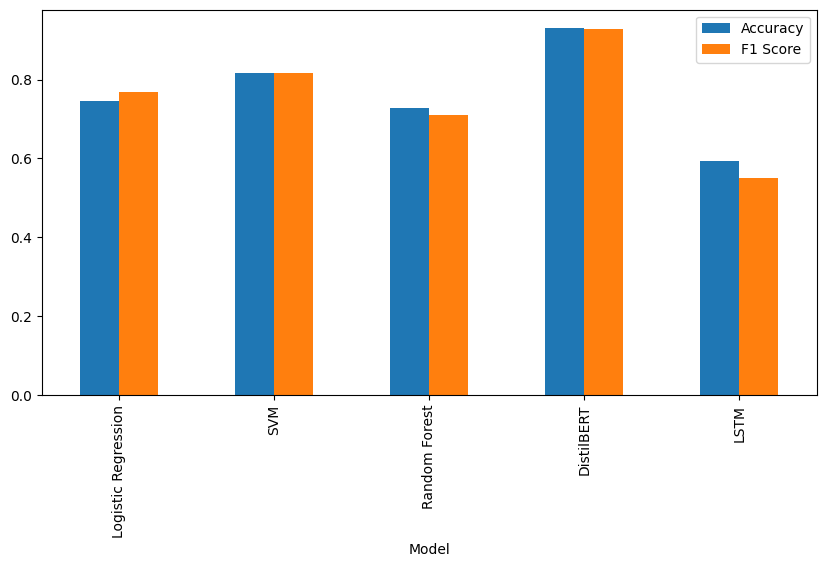

In [ ]:
df_results.plot(x="Model", y=["Accuracy", "F1 Score"], kind="bar", figsize=(10,5))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


<Figure size 600x500 with 0 Axes>

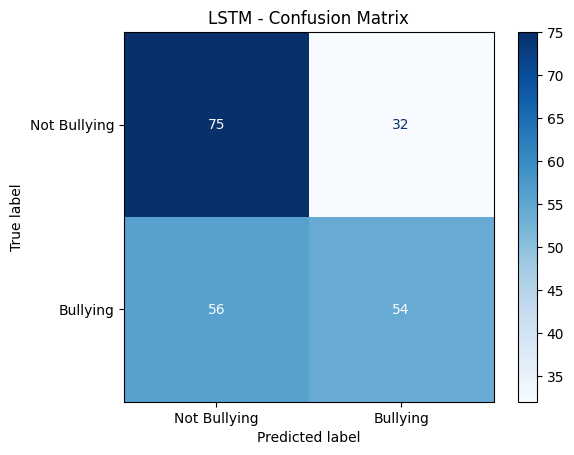

<Figure size 600x500 with 0 Axes>

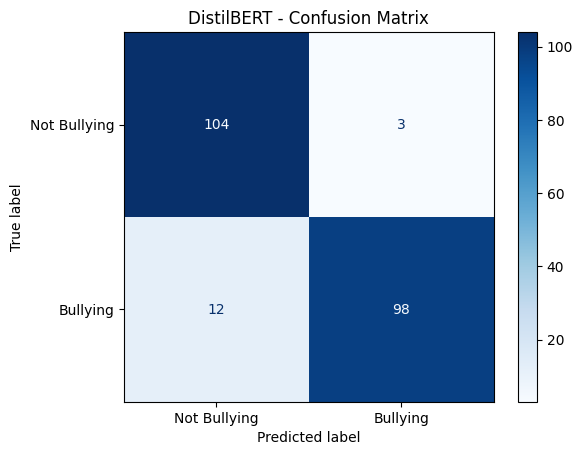

<Figure size 600x500 with 0 Axes>

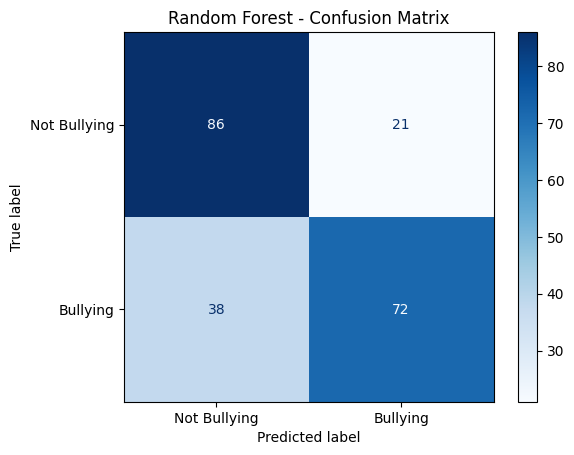

<Figure size 600x500 with 0 Axes>

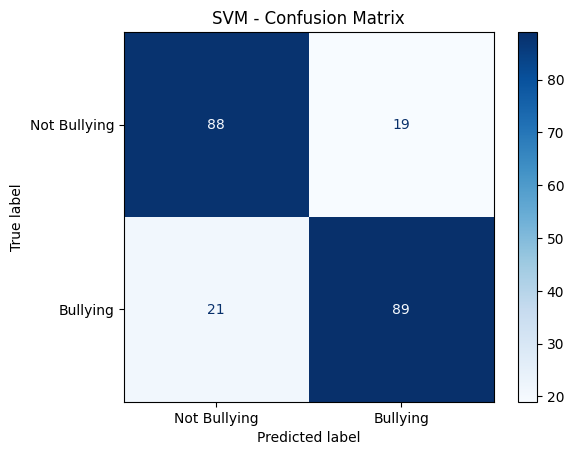

<Figure size 600x500 with 0 Axes>

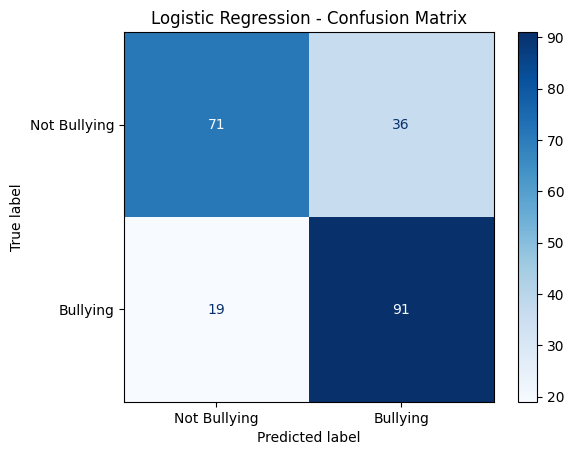

In [ ]:
models = {
    "LSTM": lstm_preds,
    "DistilBERT": bert_preds,
    "Random Forest": rafo_preds,
    "SVM": svm_preds,
    "Logistic Regression": log_preds
}

for name, pred in models.items():
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Not Bullying", "Bullying"])

    plt.figure(figsize=(6,5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
